In [1]:
from sklearn.svm import SVR 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### data import

In [2]:
data = pd.read_csv('data.csv', delimiter=';')

#### data normalization

In [3]:
data_norm = data.copy()
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()
data_norm['x'] = mmsx.fit_transform(data['x'].values.reshape(-1,1))
data_norm['y'] = mmsy.fit_transform(data['y'].values.reshape(-1,1))

In [4]:
x = data_norm['x'].values.reshape(-1,1)
y = data_norm['y'].ravel()

#### SVR hyperparameter selection

In [5]:
GAMMA = 1
KERNEL ='rbf'
EPSILON = 0.05
C = 100

#### SVR model 

In [6]:
rgr = SVR(C=C, kernel=KERNEL, epsilon=EPSILON, gamma = GAMMA)

In [7]:
print('below SVR hyper-parameters:')
rgr.get_params()

below SVR hyper-parameters:


{'C': 100,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.05,
 'gamma': 1,
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### SVR training

In [8]:
rgr.fit(x,y)

SVR(C=100, epsilon=0.05, gamma=1)

### SVR prediction using **python library** (*scikit-learn*)

In [9]:
yhat_sk = rgr.predict(x)
data_norm['yhat_sk'] = yhat_sk.copy()
data['yhat_sk'] = mmsy.inverse_transform(yhat_sk.reshape(-1,1))

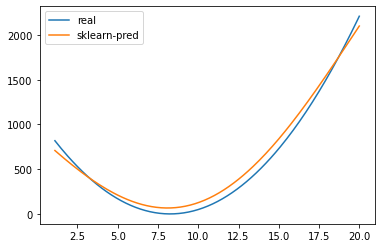

In [10]:
plt.plot(data['x'], data['y'])
plt.plot(data['x'], data['yhat_sk']);
plt.legend(['real','sklearn-pred']);

### SVR prediction using **matricial calculations** (*numpy*)

##### RBF kernel calculation

In [11]:
def rbf_kernel(X,Y, gamma):
    K = np.zeros((X.shape[0],Y.shape[0]))
    for i,x in enumerate(X):
        for j,y in enumerate(Y):
            K[i,j] = np.exp(-gamma*np.linalg.norm(x-y)**2)
    return K

In [12]:
K = rbf_kernel(rgr.support_vectors_,x, GAMMA)

##### prediction

In [13]:
yhat_np = np.dot(rgr.dual_coef_,K) + rgr.intercept_
data_norm['yhat_np'] = yhat_np.T.copy()
data['yhat_np'] = mmsy.inverse_transform(yhat_np.reshape(-1,1))

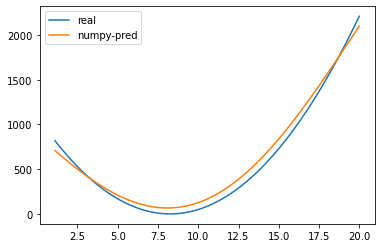

In [14]:
plt.plot(data['x'], data['y'])
plt.plot(data['x'], data['yhat_np']);
plt.legend(['real','numpy-pred']);

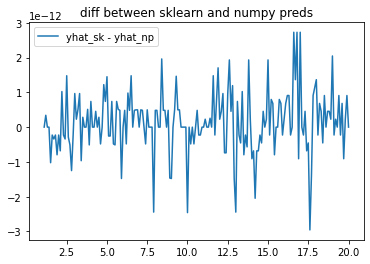

In [15]:
plt.plot(data['x'], data['yhat_sk'] - data['yhat_np'])
plt.legend(['yhat_sk - yhat_np']);
plt.title('diff between sklearn and numpy preds');

#### Theory
SVR formulation can be found here:<br>
> - Scikit-learn: https://scikit-learn.org/stable/modules/svm.html#svm-regression
> - Tutorial: http://alex.smola.org/papers/2003/SmoSch03b.pdf

In [16]:
print('Kernel shape --> ', K.shape)
print('(alpha - alpha_i*) shape -->', rgr.dual_coef_.shape)
print('b shape --> ', rgr.intercept_.shape)
print('support vectors number --> ', rgr.support_vectors_.shape[0])

Kernel shape -->  (4, 190)
(alpha - alpha_i*) shape --> (1, 4)
b shape -->  (1,)
support vectors number -->  4


##### What are Support Vectors in SVR?:
>- In SVR, support vectors are those points that lie outside the ε-tube. <br> 
>- The smaller the value of ε, the more points that lie outside the tube and hence the greater the number of support vectors
>- https://link.springer.com/chapter/10.1007/978-1-4302-5990-9_4

##### Below the Support Vectors

In [17]:
data_norm['support-vectors'] = False
data_norm.loc[np.abs(data_norm['yhat_np'] - data_norm['y']) >= EPSILON - 0.00041,'support-vectors'] = True
data['support-vectors'] = data_norm['support-vectors'].copy()

In [18]:
print('support vectors using numpy:')
list(data_norm.loc[data_norm['support-vectors'] == True,'x'])

support vectors using numpy:


[0.0, 0.7142857142857143, 0.7195767195767195, 1.0000000000000002]

In [19]:
print('support vectors using scikit-learn:')
list(rgr.support_vectors_.ravel())

support vectors using scikit-learn:


[0.0, 0.7142857142857143, 0.7195767195767195, 1.0000000000000002]

#### Plot SVR behaviour

In [20]:
data_norm['yhat+eps'], data_norm['yhat-eps'] = data_norm['yhat_np'] + EPSILON, data_norm['yhat_np'] - EPSILON

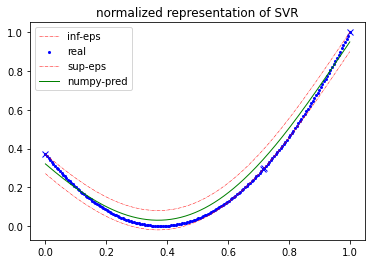

In [21]:
plt.plot(data_norm['x'], data_norm['yhat-eps'], c='r', linestyle='-.', linewidth = 0.5)
plt.scatter(data_norm['x'], data_norm['y'], c='b', marker='.', linewidth=0.1)#,  alpha=0.4)
plt.plot(data_norm['x'], data_norm['yhat+eps'], c='r', linestyle='-.', linewidth = 0.5)
plt.plot(data_norm['x'], data_norm['yhat_np'],c='g', linewidth=1)
plt.scatter(data_norm.loc[data['support-vectors'] == True,'x'],data_norm.loc[data['support-vectors'] == True,'y'], linewidth=1, c='b', marker='x')
plt.legend(['inf-eps','real','sup-eps','numpy-pred'])
plt.title('normalized representation of SVR');
#ax.set_xlim((0.99,1.01))
#ax.set_ylim((0.8,1.01))